In [55]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [56]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [58]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [59]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [60]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [61]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [62]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


Text(25.20833333333333, 0.5, 'Inches')


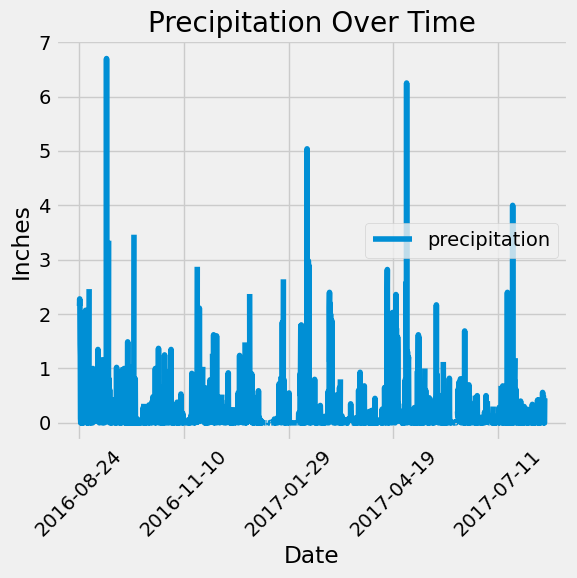

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(6, 6))
precip_df.plot(x='date', y='precipitation', ax=ax, title="Precipitation Over Time", rot=45)
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
plt.tight_layout()
print(ax.yaxis.label)
plt.show()

In [65]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precip_df['precipitation'].describe()
display(summary_statistics)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
print(f'Total number of stations: {total_stations[0][0]}')

Total number of stations: 9


In [67]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
for station, count in most_active_stations:
    print(f'Station: {station}, Observations: {count}')

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [68]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), 
                                  func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f'Most Active Station: {most_active_station_id}')
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


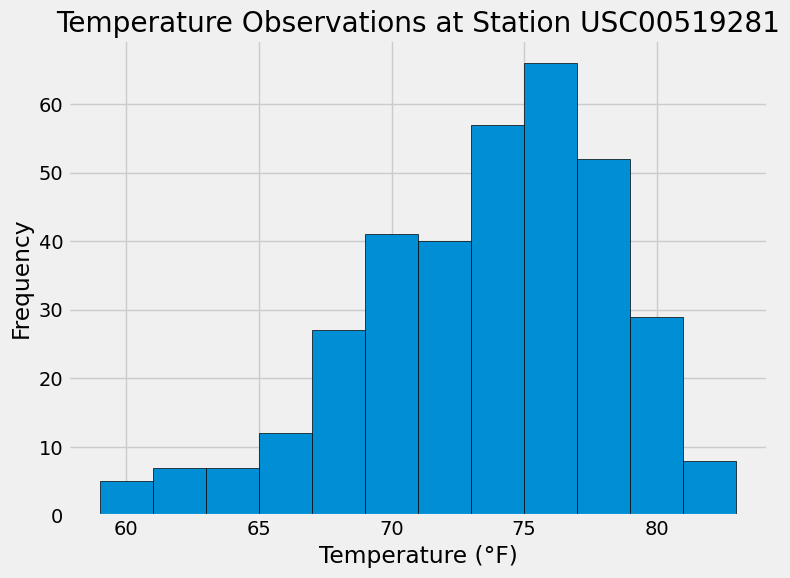

In [69]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_stations[0][0]
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=['temperature'])
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['temperature'], bins=12, edgecolor='black')
plt.title(f'Temperature Observations at Station {most_active_station_id}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [71]:
# Close Session
session.close()